# Recurrent Neural Network (RNN)
This notebook will describe RNN and then we will solve a simple sequential task.

## Introduction
Recurrent means something that occurs repeatedly. The RNN are a class of models that uses this behaviour. Generally there are three aspects to this (not all of them are mandatory, but covers all the cases).
- `Encoder`.
- `G` (The main part of RNN)
- `Decoder`

Before explaining the structure of the model, the main crux is it mainly works on sequential tasks i.e. it depends on output of previous iteration or timestamp. So, our problem has an input $x$ and target $y$, which look like this:
$
x = x(0), x(1), \ldots x(t) \\ 
y = y(0), y(1), \ldots x(t) \\
$
where, t is the timestamp or iteration.

`NOTE`: The length of $x$ and $y$ sequences need not be same.
As you can see, the target $y$ depends on previous inputs.

The RNN models does the following:
1. Encode the input $x$ into some hidden representation $h(t)$ (using `Encoder`).
2. We use a `G` function to predict the hidden state (from which we can generate output, say $z(t)$), using $h$ and hidden representation of previous output $z(t-1)$.
3. To get the output we use `Decoder` to generate output $y(t)$ from $z(t)$.

$ 
h(t) = Enc(x(t)) \\
z(t) = G(h(t), z(t-1)) \\
y(t) = Dec(z(t)) \\
$

What to do for generating z(0)? we do not have z(-1), we initialize z(-1) to be a zero vector or random vector. (Maybe there is more research into it, have to explore).

During implementation we just have to define the connection mentioned above, the pytorch will automatically unroll the loop to generate the whole model across timestamp. This can be seen from the below diagram:

![Fig. on unrolled RNN](./images/RNN_unrolled.png)


G can be any function that uses hidden representation of input and previous hidden state. Generally this is a complicated network. Why is this the case ? For that we have to see the two main problems of RNNs:
- `Vanishing gradients`: In a long sequence, the gradients get multiplied by the weight matrix (transpose) at every time step. If there are small values in the weight matrix, the norm of gradients get smaller and smaller exponentially.
    
- `Exploding gradients`: If we have a large weight matrix and the non-linearity in the recurrent layer is not saturating, the gradients will explode. The weights will diverge at the update step. We may have to use a tiny learning rate for the gradient descent to work.

Exploding gradients are prevented by clipping the gradient values. But vanishing gradients are tough to solve, this where design of G function comes to play. The goals is to give pathway for the model to remember information from the beginning, when the models goes deep. This is done by `LSTM` and `GRU`, both use gating mechanism (similar to electronic circuit, providing read, write and forget gates).


Now let us solve a practical problem, this is the problem given by Alfredo, during DL Fall 2024 course, shamelessly copying it.

## Sequence Classification
The goal is to classify sequences. 

Elements and targets are represented locally (input vectors with only one non-zero bit). The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions t1 and t2 that are either `X` or `Y`. For the DifficultyLevel.HARD case, the sequence length is randomly chosen between 100 and 110, t1 is randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60. There are 4 sequence classes Q, R, S, and U, which depend on the temporal order of X and Y.

The rules are:  
X, X -> Q,  
X, Y -> R,  
Y, X -> S,  
Y, Y -> U.  

Let us visualize the dataset.

In [23]:
from sequential_tasks import TemporalOrderExp6aSequence as QRSU
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from plot_lib import set_default, plot_state, print_colourbar

### I. Describing the Data

This is a batched dataset, we will discuss just each data point individually. We have a sequence that comprises of 4 parts.

1. Termination Letters: These are the `B` and `E`. Indicating the Beginning and End letters of the sequence.
2. The filler letters: These letters are junk and does not mean anything, they are `a, b, c, d`.
3. The Information Letters: These are the `X` and `Y`.
4. The Target Letters: The letters we want to predict, they are `Q,R,S,U`.

We have Sequence length of n, where B is the beginning (index 0) and E is the end (index n-1). Then we have X and Y at any random two location (from 1 to n-2) and there can be any filler letters between them. Now, we would like to predict Target letters from this sequence, using rules mentioned in the beginning.

Example:
BYdadYE -> U

All the letters are encoded in one-hot encoding, in the following manner.  
P = [0, 0, 0, 0, 0, 0, 0, 0]  
B = [0, 0, 0, 0, 0, 0, 1, 0]  
E = [0, 0, 0, 0, 0, 0, 0, 1]  
X = [1, 0, 0, 0, 0, 0, 0, 0]  
Y = [0, 1, 0, 0, 0, 0, 0, 0]  

a = [0, 0, 1, 0, 0, 0, 0, 0]  
b = [0, 0, 0, 1, 0, 0, 0, 0]  
c = [0, 0, 0, 0, 1, 0, 0, 0]  
d = [0, 0, 0, 0, 0, 1, 0, 0]  

What is P ? P is padding, which we add at the beginning if the sequence size is less than the max sequence length. For example, in the below case, we have (32, 9, 8). If the sequence length is less than 9, we add 0 pad at the begging to solve this.


`NOTE`: This is poor design, but the length of the whole dataset is 1000 / batch_size. This is hardcoded in the dataset. When you access the id from generator, it generates a random datapoint, the index plays no role. Also, the seed is set, we get the same batches, irrespective of ID. •`_´•

In [24]:
generator = QRSU.get_predefined_generator(difficulty_level=QRSU.DifficultyLevel.EASY, batch_size=32)
# index does not matter, it does not use this argument.
# print(len(generator))
example_batch = generator[200]
print(f"The return type is a {type(example_batch)}, with length {len(example_batch)}")
print()
print(f"shape of first item: f{example_batch[0].shape}")
print(f"first item in tuple (the input x): first element in the batch \n {example_batch[0][0]}")
# decoding the sequence
decoded_x = generator.decode_x(example_batch[0][0])
print(f"decoded value of x: {decoded_x}")
print()
print(f"shape of second item: f{example_batch[1].shape}")
print(f"second item in tuple (the target y): first element in the batch \n {example_batch[1][0]}")
# decoding the sequence
decoded_y = generator.decode_y(example_batch[1][0])
print(f"decoded value: {decoded_y}")

The return type is a <class 'tuple'>, with length 2

shape of first item: f(32, 9, 8)
first item in tuple (the input x): first element in the batch 
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
decoded value of x: BbXcXcbE

shape of second item: f(32, 4)
second item in tuple (the target y): first element in the batch 
 [1. 0. 0. 0.]
decoded value: Q


### II. Designing the Model
`Note`: In pytorch, the RNN eludes to Elman RNN, which is just FC layers on two inputs (h, z) and adding it with ReLU activation. This model suffers from the two problems we described before (vanishing gradients and exploding gradients).

We define two models:
1. RNN (Elman) [here](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
2. LSTM [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In this experiment, we use pytorch predefined LSTM and RNN networks (from hidden size to output size).

In [25]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.elman_rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 0 - output
        # 1 - hidden state
        h = self.elman_rnn(x)[0]
        o = self.linear(h)
        return o 

class LSTMRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        o = self.linear(h) 
        return o

### III. Training and Testing of RNN
The goal is we iterate through each batch. We pass the batch data to the RNN and then extract the last output of the sequence (z(l-1), where l is sequence length) and compute the argmax to get the target (since, it is a one-hot encoding).

Example: 
`[0.6, 0.2, 0.1, 0.1] -> 0`

We compute the loss and do gradient descent step.


`NOTE`: The training of Elman RNN can be erratic, 

In [26]:
def train(model, train_data_gen, criterion, optimizer, device):
    model.train()

    num_correct = 0
    for batch_id in range(len(train_data_gen)):
        data, target = train_data_gen[batch_id]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)

        output = model(data)
        output = output[:, -1, :]

        target = target.argmax(dim=1)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
    
    return num_correct, loss.item()

def test(model, test_data_gen, criterion, device):
    model.eval()
    num_correct = 0

    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            output = output[:, -1, :]
            target = target.argmax(dim=1)
            loss = criterion(output, target)
            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

In [27]:
# this is for default setting for printing plots
set_default()

# function that trains and tests
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

[Epoch 1/10] loss: 1.3813, acc: 25.10% - test_loss: 1.4044, test_acc: 23.49%
[Epoch 2/10] loss: 1.3900, acc: 26.92% - test_loss: 1.3963, test_acc: 23.99%
[Epoch 3/10] loss: 1.3868, acc: 21.37% - test_loss: 1.3859, test_acc: 23.89%
[Epoch 4/10] loss: 1.3759, acc: 26.61% - test_loss: 1.3890, test_acc: 25.81%
[Epoch 5/10] loss: 1.3910, acc: 24.29% - test_loss: 1.3873, test_acc: 26.01%
[Epoch 6/10] loss: 1.3850, acc: 25.71% - test_loss: 1.3894, test_acc: 23.89%
[Epoch 7/10] loss: 1.3843, acc: 25.50% - test_loss: 1.3839, test_acc: 25.40%
[Epoch 8/10] loss: 1.3889, acc: 24.60% - test_loss: 1.3746, test_acc: 25.00%
[Epoch 9/10] loss: 1.3854, acc: 25.30% - test_loss: 1.3867, test_acc: 23.79%
[Epoch 10/10] loss: 1.3859, acc: 26.92% - test_loss: 1.3854, test_acc: 26.11%


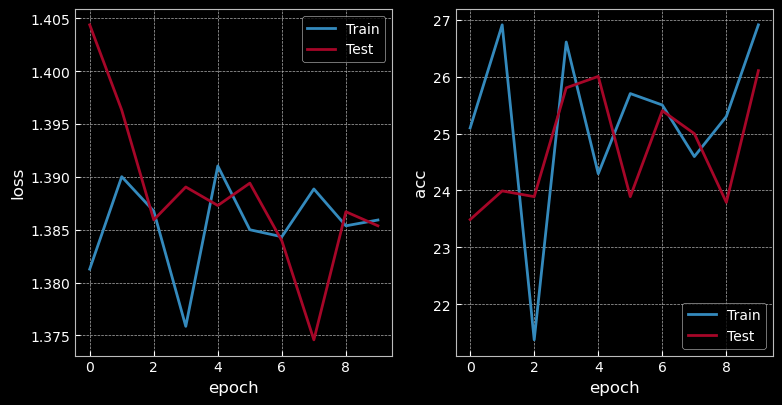

In [28]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = ElmanRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

[Epoch 1/10] loss: 1.3909, acc: 36.69% - test_loss: 1.3394, test_acc: 49.70%
[Epoch 2/10] loss: 1.3338, acc: 46.27% - test_loss: 1.3006, test_acc: 48.79%
[Epoch 3/10] loss: 1.2424, acc: 49.19% - test_loss: 1.2622, test_acc: 48.99%
[Epoch 4/10] loss: 1.2389, acc: 51.01% - test_loss: 1.1844, test_acc: 51.11%
[Epoch 5/10] loss: 1.1270, acc: 54.74% - test_loss: 1.1485, test_acc: 59.07%
[Epoch 6/10] loss: 1.1136, acc: 55.85% - test_loss: 1.0486, test_acc: 55.14%
[Epoch 7/10] loss: 1.0790, acc: 59.48% - test_loss: 1.0555, test_acc: 55.65%
[Epoch 8/10] loss: 1.0544, acc: 60.28% - test_loss: 1.0789, test_acc: 62.70%
[Epoch 9/10] loss: 0.9952, acc: 62.50% - test_loss: 0.9336, test_acc: 63.00%
[Epoch 10/10] loss: 0.9875, acc: 67.74% - test_loss: 0.9293, test_acc: 72.88%


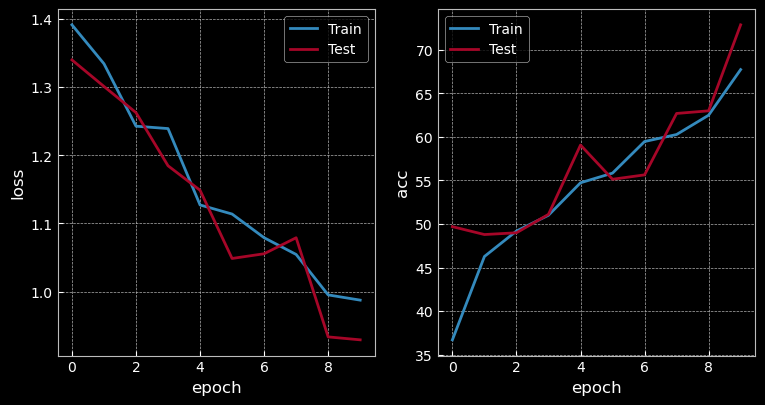

In [29]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = LSTMRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

[Epoch 100/100] loss: 0.0151, acc: 100.00% - test_loss: 0.0086, test_acc: 100.00%


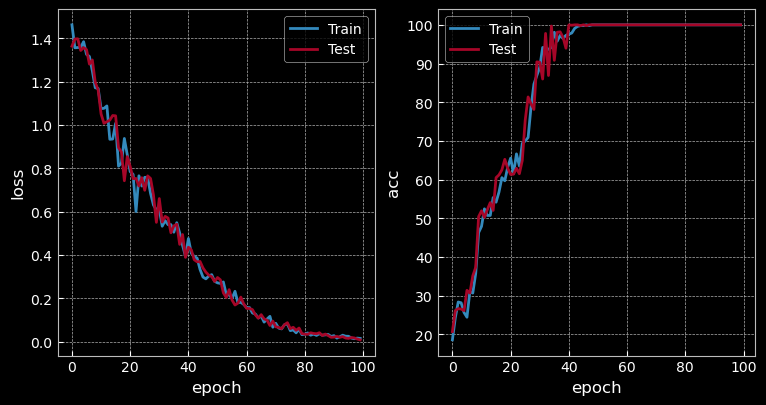

In [32]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = ElmanRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

[Epoch 100/100] loss: 0.0004, acc: 100.00% - test_loss: 0.0005, test_acc: 100.00%


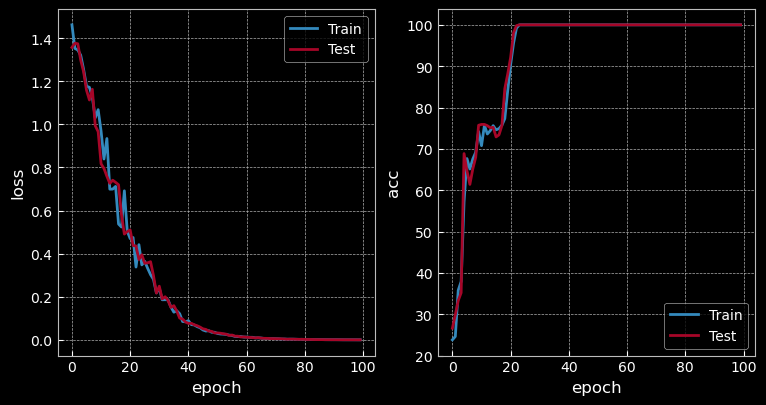

In [31]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = LSTMRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)